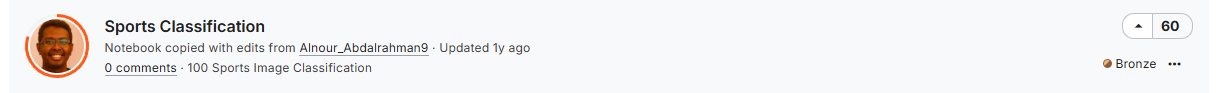

In [1]:
import numpy as np
import pandas as pd
import os
import random
from PIL import Image
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.optimizers import Adam

In [2]:
train_dir = 'D:\code_study\ML_CODE\dataSets\Sports_Image_Classification_100/train'
train_dir = train_dir.replace('\\','/')
test_dir= 'D:\code_study\ML_CODE\dataSets\Sports_Image_Classification_100/test'
test_dir = test_dir.replace('\\','/')
val_dir = 'D:\code_study\ML_CODE\dataSets\Sports_Image_Classification_100/valid'
val_dir = val_dir.replace('\\','/')

In [3]:
def show_random_images_with_labels(main_folder, num_images=5):
  """
  Displays a random selection of images from subfolders of the main folder,
  along with their corresponding labels (subfolder names).

  Args:
    main_folder: Path to the main folder containing subfolders of images.
    num_images: Number of images to display (default: 5).
  """

  subfolders = [os.path.join(main_folder, f) for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]
  random.shuffle(subfolders)  # Randomize the order of subfolders

  fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 5))
  for i, subfolder in enumerate(subfolders[:num_images]):
    image_paths = [os.path.join(subfolder, f) for f in os.listdir(subfolder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(image_paths)  # Randomize the order of images within the subfolder
    image_path = image_paths[0]  # Select the first random image

    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(os.path.basename(image_path) + f" ({os.path.basename(subfolder)})", fontsize=10)  # Add label in title

  plt.tight_layout()
  plt.show()

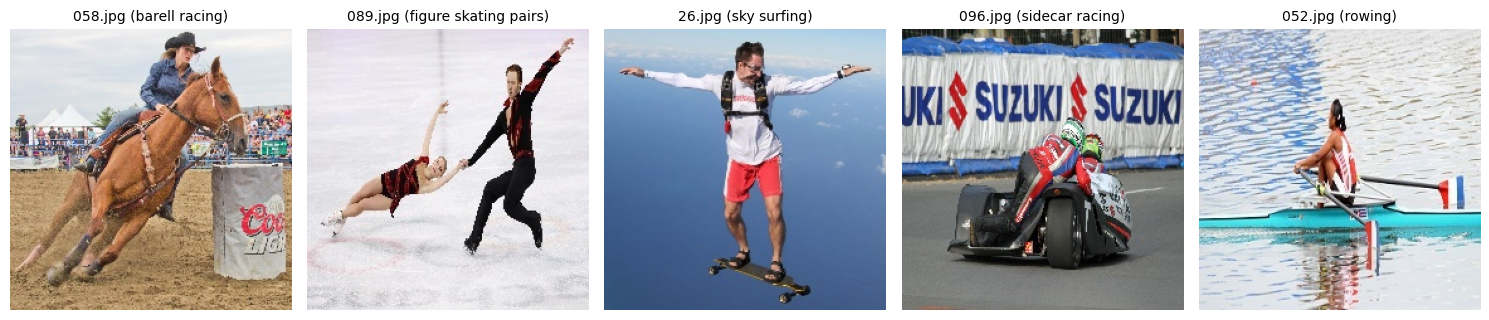

In [4]:
show_random_images_with_labels(train_dir,5)

In [5]:
train_datagen = ImageDataGenerator( zoom_range=0.2,
                            width_shift_range=0.2,height_shift_range=0.2)


train_dg = train_datagen.flow_from_directory(train_dir,
                                    class_mode = "categorical",
                                    target_size = (299, 299),
                                    batch_size = 128,
                                    shuffle = True,
                                    seed = 42)

Found 13492 images belonging to 100 classes.


In [6]:
val_datagen = ImageDataGenerator()
validation_dg = val_datagen.flow_from_directory(val_dir,
                                      class_mode = "categorical",
                                      target_size = (299, 299),
                                      batch_size = 128,
                                      shuffle = False,
                                      seed = 42)

Found 500 images belonging to 100 classes.


In [7]:
testing_dg = val_datagen.flow_from_directory(test_dir,
                                      class_mode = "categorical",
                                      target_size = (299, 299),
                                      batch_size = 128,
                                      shuffle = False,
                                      seed = 42)

Found 500 images belonging to 100 classes.


In [8]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model

# Load the EfficientNetB0 model pre-trained on ImageNet
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(229, 229, 3))

# Freeze the base model layers (optional, can be fine-tuned later)
for layer in base_model.layers:
  layer.trainable = False

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.25)(x)
predictions = Dense(100, activation="softmax")(x)  # Adjust output size for 500 species

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

16711680/16705208 [==============================] - 4s 0us/step


In [9]:
opt = Adam(learning_rate=0.005)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [10]:
history = model.fit(
      train_dg,
      epochs=30,
      workers=10,
      validation_data = validation_dg,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True), 
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)

Epoch 1/30
106/106 [==============================] - 143s 1s/step - loss: 2.1591 - accuracy: 0.5154 - val_loss: 0.3072 - val_accuracy: 0.9200
Epoch 2/30
106/106 [==============================] - 50s 450ms/step - loss: 0.4733 - accuracy: 0.8690 - val_loss: 0.2078 - val_accuracy: 0.9460
Epoch 3/30
106/106 [==============================] - 49s 440ms/step - loss: 0.3391 - accuracy: 0.9074 - val_loss: 0.1730 - val_accuracy: 0.9460
Epoch 4/30
106/106 [==============================] - 64s 583ms/step - loss: 0.2620 - accuracy: 0.9244 - val_loss: 0.1620 - val_accuracy: 0.9500
Epoch 5/30
106/106 [==============================] - 49s 439ms/step - loss: 0.2335 - accuracy: 0.9326 - val_loss: 0.1658 - val_accuracy: 0.9500
Epoch 6/30
106/106 [==============================] - 47s 425ms/step - loss: 0.2132 - accuracy: 0.9364 - val_loss: 0.1385 - val_accuracy: 0.9600
Epoch 7/30
106/106 [==============================] - 49s 440ms/step - loss: 0.1857 - accuracy: 0.9474 - val_loss: 0.1579 - val_accu

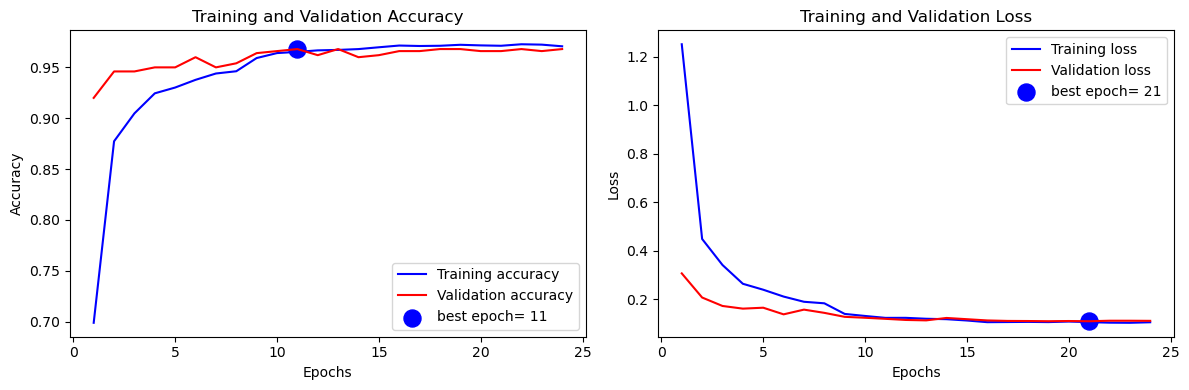

In [11]:
# Extracting training and validation metrics from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

# Plotting accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(train_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()







# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
predictions=model.evaluate(testing_dg)

4/4 [==============================] - 5s 1s/step - loss: 0.0871 - accuracy: 0.9720


In [13]:
# Get true labels
true_labels = testing_dg.classes

# Use the model to predict the classes
predicted_labels = np.argmax(model.predict(testing_dg), axis=1)

# Display classification report
print("Classification Report:\n", classification_report(true_labels, predicted_labels, target_names=testing_dg.class_indices.keys()))

Classification Report:
                        precision    recall  f1-score   support

           air hockey       1.00      1.00      1.00         5
      ampute football       1.00      1.00      1.00         5
              archery       1.00      1.00      1.00         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       1.00      1.00      1.00         5
         balance beam       0.83      1.00      0.91         5
        barell racing       1.00      1.00      1.00         5
             baseball       1.00      0.80      0.89         5
           basketball       0.83      1.00      0.91         5
       baton twirling       1.00      1.00      1.00         5
            bike polo       0.83      1.00      0.91         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.60      0.75         5
              bobsled       0.83      1.00      0.91         5
              bowling       1.